### 머신러닝기반데이터분석 2분반 기말고사 5조
##### 데이터사이언스학과 김수아, 박서진, 오서연

### _Don't PERget Me_: 여행지 분위기 기반 머신러닝 향수 추천 시스템 프로젝트

---
0. 문제정의하기(Problem Define)
1. 라이브러리 불러오기(Libraries Setting)
2. 데이터 수집하기(Data Collection)
3. 데이터 탐색하기(Data Exploration)
4. 전처리하기(Preprocessing)
5. 모델링하기(Modeling)
    - 5.1 여행지 분위기 키워드 추출 (by. NMF)
    - 5.2 키워드와 향수 노트 유사도 측정
6. 모델 평가하기(Evaluation)
---

#### 0. 문제정의하기(Problem Define)

#### 1. 라이브러리 불러오기(Libraries Setting)

In [2]:
# 라이브러리 임포트
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import geopandas as gpd
from collections import Counter
import ast


#### 2. 데이터 수집하기
- 데이터 경로를 통해 csv 파일 데이터 프레임화

In [3]:
# 데이터 파일 경로 설정
destination_file_path = '../Data/Prompting/dataset/destination_mood.csv'
perfume_file_path = '../Data/preprocess-data/final_perfume-info.csv'

destinations = pd.read_csv(destination_file_path)
perfumes_raw = pd.read_csv(perfume_file_path)

In [4]:
destinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ranking      100 non-null    int64 
 1   city         100 non-null    object
 2   description  100 non-null    object
 3   City Mood    100 non-null    object
 4   nation       100 non-null    object
dtypes: int64(1), object(4)
memory usage: 4.0+ KB


### 여행지 데이터 정보 설명
- ranking : 도시 순위
- city : 도시 이름
- description : 도시의 관광지 설명
- City Mood : 도시를 설명하는 텍스트
- nation : 국가 이름

In [5]:
# 여행지 데이터 확인 - GPT 프롬프팅까지 완료한 데이터
destinations.head(2)

,ranking,city,description,City Mood,nation
0,1,London,1. The iconic Big Ben and Houses of Parliament...,"London, the capital of the United Kingdom, is ...",United Kingdom
1,2,Paris,"1. Eiffel Tower: The iconic symbol of Paris, t...","Paris, the capital city of France, is a timele...",France


In [171]:
perfumes_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074 entries, 0 to 1073
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          1074 non-null   object
 1   company       1074 non-null   object
 2   image         1074 non-null   object
 3   for_gender    1074 non-null   object
 4   main accords  1045 non-null   object
 5   top notes     807 non-null    object
 6   middle notes  878 non-null    object
 7   base notes    807 non-null    object
 8   notes         900 non-null    object
dtypes: object(9)
memory usage: 75.6+ KB


### 향수 데이터 정보 설명
- name : 향수 이름
- company : 향수 회사 이름
- image : 향수 이미지
- for_gender : 성별
- main_accords : 각 조향은 시트러스, 플로럴, 우디 등과 같은 특정 향수 그룹을 대표함
조향 개발 과정에서는 에센셜 오일의 비율을 조절하고, 테스트 스트립 방식을 사용하여 새로운 조합마다 비율을 정제하고 결과를 평가받음
- top notes : 휘발도가 가장 높은 향
- middle notes : 중간 단계의 휘발도를 갖는 향로들로 조향사가 표현하고자 하는 이미지와 컨셉을 결정하는 중요한 요소
- base notes : 탑노트와 미들노트가 다 날아가고 남는 향기로 가장 무거운 재료들로 이루어진 향
- notes : 모든 노트

In [6]:
perfumes_raw.head(2)

,name,company,image,for_gender,main accords,top notes,middle notes,base notes,notes
0,Angels' Share By Kilian,By Kilian,https://fimgs.net/mdimg/perfume/375x500.62615.jpg,for women and men,"{'woody': 100.0, 'sweet': 92.6987, 'warm spicy...",['Cognac'],"['Cinnamon', 'Tonka Bean', 'Oak']","['Praline', 'Vanilla', 'Sandalwood']","woody, sweet, warm spicy, vanilla, cinnamon, a..."
1,My Way Giorgio Armani,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.62036.jpg,for women,"{'white floral': 100.0, 'citrus': 60.4322, 'tu...","['Orange Blossom', 'Bergamot']","['Tuberose', 'Indian Jasmine']","['White Musk', 'Madagascar Vanilla', 'Virginia...","white floral, citrus, tuberose, animalic, Oran..."


#### 3. 데이터 탐색하기
##### 3.1 상위 10개 회사별 향수 보유 현황 시각화
- company 컬럼을 기준으로 가장 많은 향수를 보유한 상위 10개의 회사 선별
- 수직 막대그래프로 시각화
    - x축: 회사 이름
    - y축: 향수 개수
- Insight: 향수 산업에서 주요 플레이어들의 시장 점유율을 이해하고, 각 회사의 시장 내 입지를 비교 가능

C:\Users\82104\AppData\Local\Temp\ipykernel_30116\1164791552.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=company_counts_updated.values, x=company_counts_updated.index, palette='mako')


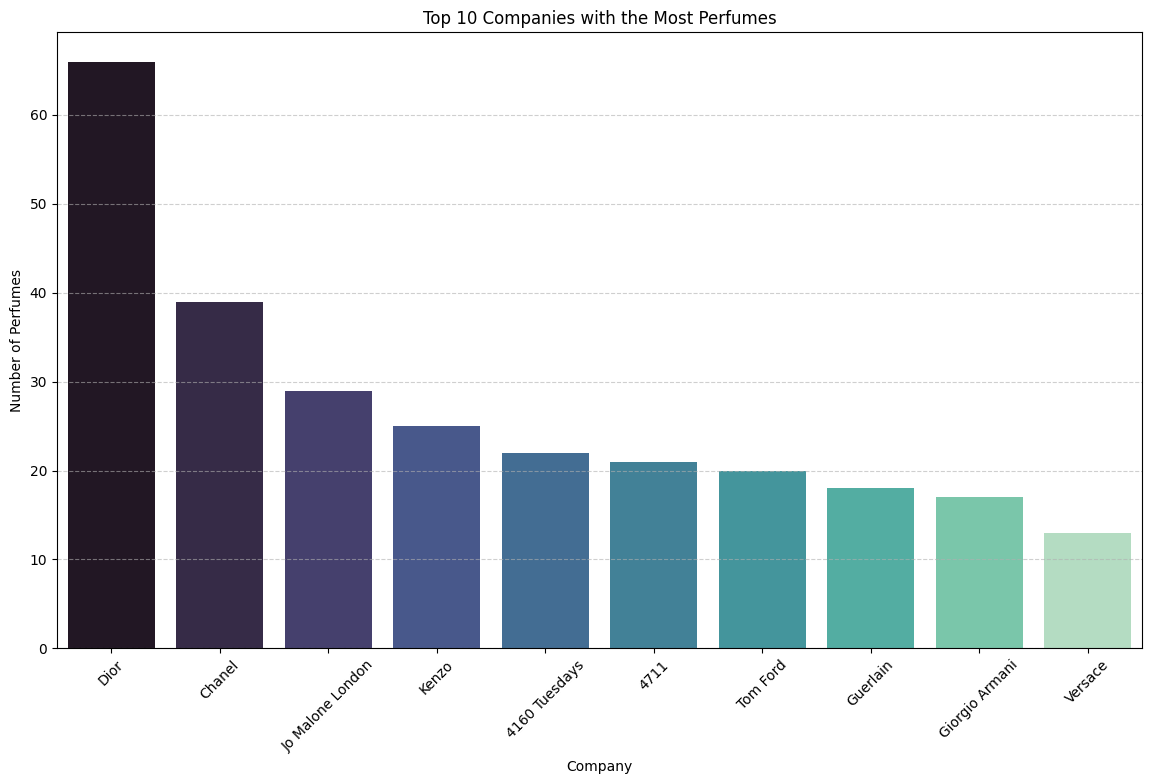

In [7]:
# Dior 과 Christian Dior 회사 합치기 (같은 회사이므로)
perfumes_raw['company'] = perfumes_raw['company'].replace(['Dior', 'Christian Dior'], 'Dior')

# 회사별 향수 개수 세기
company_counts_updated = perfumes_raw['company'].value_counts().head(10)

# 회사명 개수로 수직 그래프 그리기
plt.figure(figsize=(14, 8))
sns.barplot(y=company_counts_updated.values, x=company_counts_updated.index, palette='mako')
plt.title('Top 10 Companies with the Most Perfumes')
plt.ylabel('Number of Perfumes')
plt.xlabel('Company')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

##### 3-2. 향수 데이터셋에서 주요 향 구성요소의 빈도 탐색 및 시각화

- 수직 막대그래프로 시각화
    - x축: Accords
    - y축: Frequency
- Insight: 향수 산업에서 주요 향의 사용 빈도와 특정 향수 계열의 인기 파악

C:\Users\82104\AppData\Local\Temp\ipykernel_30116\2500986588.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accord_names, y=accord_values, palette='mako')


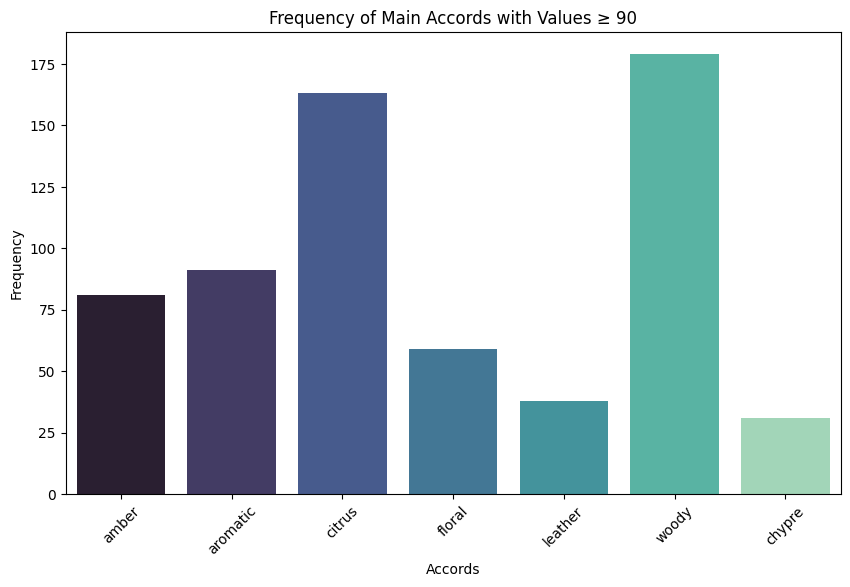

In [8]:
# 텍스트 전처리 전, notes 열에서 결측치가 있는 행은 제거하고 진행
# 결측치가 존재하는 경우, np.nan으로 결측치가 처리되어 float 타입으로 인식되어 전처리가 불가능함
perfumes = perfumes_raw.dropna(subset=['main accords','notes'])

def count_chypre_notes(perfumes, notes):
    chypre_count = 0
    for notes_list in perfumes['notes']:
        # 모든 향을 소문자로 변환하고 공백을 제거
        notes_list = notes_list.lower().replace(' ', '')
        # 쉼표로 분리하여 리스트 생성
        notes_list = notes_list.split(',')
        # 모든 지정된 노트가 존재하는지 확인
        if all(note in notes_list for note in notes):
            chypre_count += 1
    return chypre_count

# oakmoss, bergamot, patchouli를 모두 포함하는 향수의 수 계산
specified_notes = ["oakmoss", "bergamot", "patchouli"]
chypre_count = count_chypre_notes(perfumes, specified_notes)

# 'main accords'에서 값이 90 이상인 향들의 빈도수를 계산
def count_filtered_accords(perfumes, specified_accords):
    filtered_accord_counts = {accord: 0 for accord in specified_accords}
    for accords_json in perfumes['main accords']:
        accords_dict = json.loads(accords_json.replace("'", "\""))  # JSON으로 변환
        for accord, value in accords_dict.items():
            if accord in specified_accords and float(value) >= 90:
                filtered_accord_counts[accord] += 1
    return filtered_accord_counts

# 주요 향 목록
specified_accords = ["amber", "aromatic", "citrus", "floral", "leather", "woody"]
filtered_accord_counts = count_filtered_accords(perfumes, specified_accords)

# 바 차트로 시각화
accord_names = list(filtered_accord_counts.keys()) + ['chypre']  # 'chypre' 추가
accord_values = list(filtered_accord_counts.values()) + [chypre_count]  # chypre_count 추가

plt.figure(figsize=(10, 6))
sns.barplot(x=accord_names, y=accord_values, palette='mako')
plt.title('Frequency of Main Accords with Values ≥ 90')
plt.xlabel('Accords')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


##### 3-3. 여행지 데이터셋에서 나라별 빈도 탐색 및 시각화
- 막대 그래프를 사용하여 시각화
    - x축 : Nation
    - y축 : Frequency

- Insight : 여행지 Top 100에서 각 국가가 차지하는 정도 파악

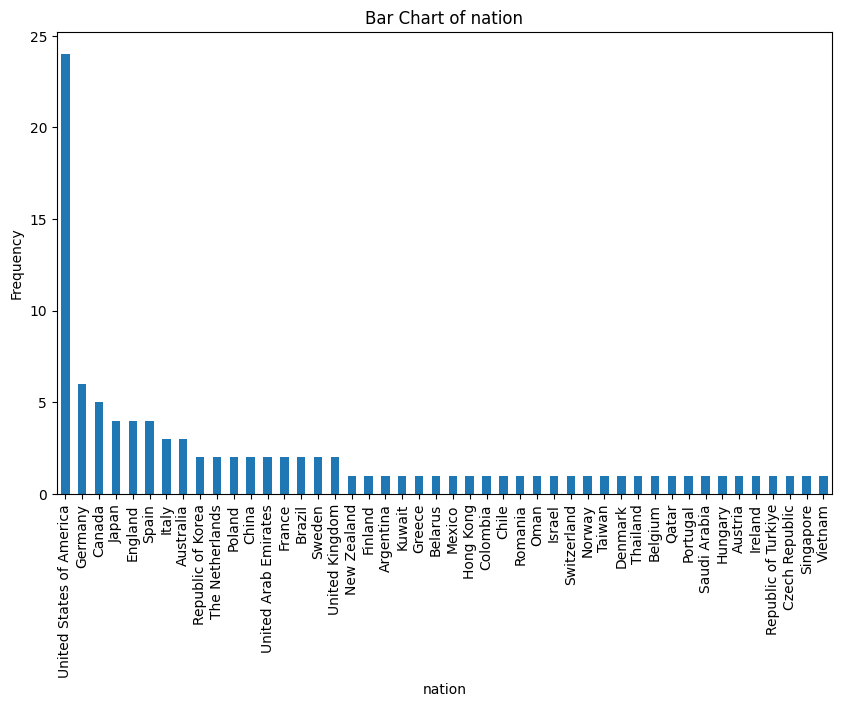

In [9]:
# 특정 열을 선택합니다.
column_name = 'nation'  # 시각화할 열 이름을 설정합니다.
data = destinations[column_name]

# 막대그래프를 그립니다.
plt.figure(figsize=(10, 6))
data.value_counts().plot(kind='bar')
plt.title(f'Bar Chart of {column_name}')
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.show()


##### 3-4. 여행지 데이터셋에서 나라별 빈도 탐색 및 시각화
- 지도를 사용하여 시각화
    - x : longitude
    - y : latitude
- Insight : top 100 국가 중 가장 많은 빈도를 보이는 국가 top 5를 뽑아 파악함

In [29]:
#pip install pandas geopandas matplotlib
#최초 실행 시 한 번만 필요

C:\Users\82104\AppData\Local\Temp\ipykernel_30116\1262039017.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


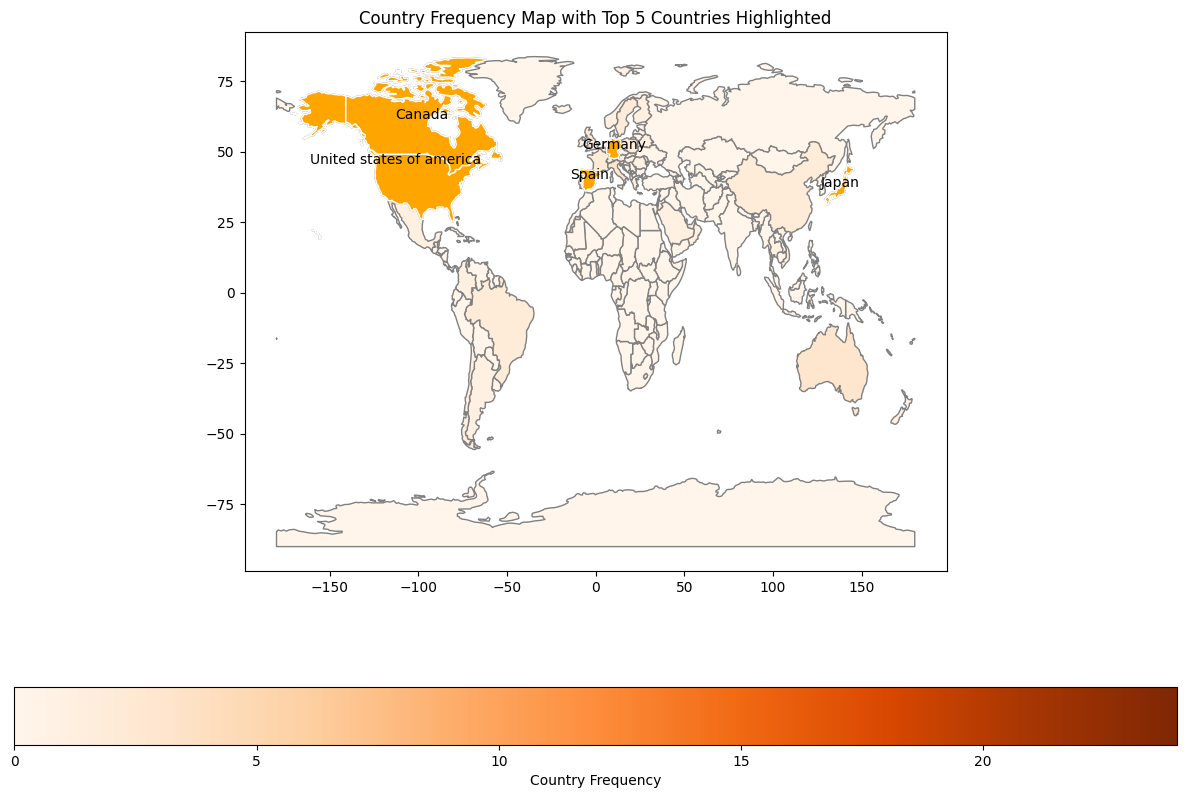

In [10]:
# 나라별 빈도 계산
nation_counts = destinations['nation'].value_counts()

# GeoPandas 세계 지도 데이터 가져오기
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 나라 이름을 소문자로 변환하여 병합 준비
world['name'] = world['name'].str.lower()
nation_counts.index = nation_counts.index.str.lower()

# GeoPandas 데이터프레임과 빈도 데이터 병합
world = world.set_index('name').join(nation_counts.rename('counts'))

# 빈도가 NaN인 값을 0으로 설정
world['counts'] = world['counts'].fillna(0)

# 상위 5개 국가 추출
top_5_nations = nation_counts.head(6).index

# 지도 시각화
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# 빈도에 따라 색상 설정 (기본 지도 색상을 주황색으로 설정)
world.plot(column='counts', ax=ax, legend=True,
           legend_kwds={'label': "Country Frequency",
                        'orientation': "horizontal"},
           cmap='Oranges', edgecolor='gray')

# 상위 5개 국가는 파란색으로 표시
top_5 = world.loc[world.index.isin(top_5_nations)]
top_5.plot(ax=ax, color='orange', edgecolor='white')

# 나라 이름 표시 (검은색 텍스트)
for idx, row in top_5.iterrows():
    ax.annotate(text=row.name.capitalize(), xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center', fontsize=10, color='black')

# 제목 추가
plt.title('Country Frequency Map with Top 5 Countries Highlighted')
plt.show()


#### 4. 전처리 하기
##### 4.1 향수 데이터 전처리 하기
- 'name' 열을 기준으로 중복 행 제거
- Main Accords, top/middle/base notes들 텍스트 한 군데('notes' 열 새로 생성)로 합하기
    - 향수 전처리 데이터를 'notes' 열 하나로 보기 위하여

In [11]:
perfumes_raw.info()    #크롤링 할 때 애초에 main accords, top/middle/base notes가 없는 데이터도 있어서 non-null이 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074 entries, 0 to 1073
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          1074 non-null   object
 1   company       1074 non-null   object
 2   image         1074 non-null   object
 3   for_gender    1074 non-null   object
 4   main accords  1045 non-null   object
 5   top notes     807 non-null    object
 6   middle notes  878 non-null    object
 7   base notes    807 non-null    object
 8   notes         900 non-null    object
dtypes: object(9)
memory usage: 75.6+ KB


In [12]:
destinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ranking      100 non-null    int64 
 1   city         100 non-null    object
 2   description  100 non-null    object
 3   City Mood    100 non-null    object
 4   nation       100 non-null    object
dtypes: int64(1), object(4)
memory usage: 4.0+ KB


### 데이터 전처리
- 텍스트 데이터 전처리 함수화
- 함수로 지정해둔 것을 불러올 예정

In [33]:
# NLTK 데이터 다운로드 (최초 실행 시 한 번만 필요)
# nltk.download('stopwords')

* 텍스트 전처리
    - 소문자 변환
        - 동일한 단어가 다른 단어로 취급되는 것을 방지하기 위함
    - 불용어 제거
        - 텍스트의 중요한 의미를 좀 더 명확하게 도출하기 위해 분석에 큰 도움이 되지 않는 너무 일반적인 단어들을 제거함
    - 어간 추출
        - 단어의 여러 형태를 하나의 단일 형태로 통일시키기 위해 단어의 어간을 찾아서 변환함

In [13]:
# 불용어 목록 가져오기
stop_words = set(stopwords.words('english'))
# 어간 추출기 설정
stemmer = PorterStemmer()

# 텍스트 전처리 함수 정의
def preprocess_text(text):
    # 소문자 변환
    text = text.lower()
    
    # 불용어 제거 및 어간 추출
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    
    # 전처리된 단어들을 다시 하나의 문자열로 결합
    return ' '.join(words)

In [14]:
# 텍스트 전처리 전, notes 열에서 결측치가 있는 행은 제거하고 진행
# 결측치가 존재하는 경우, np.nan으로 결측치가 처리되어 float 타입으로 인식되어 전처리가 불가능함
perfumes = perfumes_raw.dropna(subset=['notes'])

In [15]:
# 데이터 프레임의 텍스트 열 전처리

# 향수 텍스트 열 전처리
text_perfume = 'notes'   # 텍스트 데이터가 있는 열의 이름 미리 지정
perfumes[text_perfume] = perfumes[text_perfume].apply(preprocess_text)

# 여행지 텍스트 열 전처리
text_city = 'City Mood'  # 텍스트 데이터가 있는 열의 이름 미리 지정
destinations[text_city] = destinations[text_city].apply(preprocess_text)

C:\Users\82104\AppData\Local\Temp\ipykernel_30116\1999258345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perfumes[text_perfume] = perfumes[text_perfume].apply(preprocess_text)


- 텍스트 전처리 (TF-IDF)
    - 단어의 중요도를 정량화하고, 특정 문서에서 특정 단어가 얼마나 중요한지를 파악하기 위해 사용
        - TF(Term Frequency, 단어 빈도):문서 내에서 특정 단어가 얼마나 자주 등장하는지를 측정
        - IDF (Inverse Document Frequency, 역문서 빈도): 전체 문서 집합에서 단어의 출현 빈도에 대한 역수를 측정
    - 이 두가지 지표를 결합하여 TF-IDF 점수를 얻음

In [37]:
# # TF-IDF 벡터화
# vectorizer = TfidfVectorizer()
# tfidf_perfume = vectorizer.fit_transform(perfumes[text_perfume])

# vectorizer = TfidfVectorizer()
# tfidf_city = vectorizer.fit_transform(destinations[text_city])

In [16]:
# 모든 텍스트 데이터에 대해 fit_transform 수행
vectorizer = TfidfVectorizer()
all_texts = perfumes['notes'].tolist() + destinations['City Mood'].tolist()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# perfumes와 destinations의 TF-IDF 행렬 분리
tfidf_perfume = tfidf_matrix[:len(perfumes)]
tfidf_city = tfidf_matrix[len(perfumes):]

#### 5. 모델링하기
- NMF (Non-negative Matrix Factorization)
- Cosine Similarity
- 함수화 해서 불러와줄 예정

##### 5.1 여행지 분위기 키워드 추출 (by. NMF)
##### 여행지 분위기 추출 라벨
- 팀원 셋이 임의적으로 분위기를 선정하여 추출함
    - **자연 경관**을 표현하는 형용사 : picturesque(그림 같은), peaceful(평화로운), grand(웅장한), tranquil(고요한), lush(푸르른), exquisite(황홀한)
    - **도시와 문화**를 표현하는 형용사 : vibrant(활기찬), bustling(번화한), traditional(전통적인), cultural(문화적인), unique(독특한), trendy(유행하는)
    - **휴양지**를 표현하는 형용사 : relaxing(편안한), romantic(낭만적인), luxurious(화려한), exotic(이국적인)
    - **모험과 액티비티**를 표현하는 형용사 : adventurous(모험적인), active(활발한)

### Non-negative Matrix Factorization (비음수 행렬 분해, NMF)
- Non-negative Matrix Factorization은 Matrix Factorization의 한 종류로, 분해된 행렬 \( P \)와 \( Q \)의 모든 요소가 비음수(0 또는 양수)라는 제약 조건이 있는 방법임
- 데이터가 자연수나 비음수로 구성되어 있을 때 유용함

- NMF는 다음과 같이 표현됨:

$$ V \approx W \cdot H $$

여기서 $V$는 원래의 행렬, $W$와 $H$는 비음수 행렬을 의미함 
- 이 제약 조건은 결과 행렬들이 해석 가능하고 의미 있는 잠재 요인을 가지도록 도와줌
- NMF는 텍스트 마이닝, 이미지 처리, 생물정보학 등의 다양한 분야에서 사용되고 있음

### Matrix Factorization과 NMF의 주요 차이점
   - Matrix Factorization은 행렬 요소에 비음수 제약이 없으며, 요소가 음수일 수 있음
   - Non-negative Matrix Factorization은 행렬 요소가 비음수여야 함
      - 우리 프로젝트의 경우, 여행지의 분위기를 담은 텍스트를 만들었기 때문에 특히나 요소가 비음수임
      - NMF는 비음수 제약으로 인해 결과가 더 해석 가능하고 의미 있는 패턴을 도출하는 데 유리하기 때문에 NMF를 선정

In [17]:
# 여행지 분위기 추출 함수 (여러 주제, NMF 활용)
def extract_destination_moods(tfidf_matrix, destinations, n_topics=18):
    # NMF를 사용하여 주제 모델링
    nmf_model = NMF(n_components=n_topics, random_state=1)
    W = nmf_model.fit_transform(tfidf_matrix)
    
    # 각 주제를 미리 정의된 레이블로 매핑
    mood_labels = ['picturesque', 'peaceful', 'grand', 'tranquil', 'lush', 'exquisite', 
                    'vibrant', 'bustling', 'traditional', 'cultural', 'unique', 'trendy', 'relaxing', 
                    'romantic', 'luxurious', 'exotic', 'adventurous', 'active']
    topic_to_mood = {i: mood_labels[i] for i in range(n_topics)}
    
    # 각 여행지에 대해 상위 3개의 주제를 추출하여 분위기 매핑
    top_topics = np.argsort(W, axis=1)[:, -3:]
    top_moods = [[topic_to_mood[topic] for topic in topics] for topics in top_topics]
    
    destinations['keyword'] = top_moods
    
    return destinations

##### 5.2 키워드와 향수 노트 유사도 측정

In [18]:
# 추천 시스템 
def recommend_perfumes_for_destinations(destinations, tfidf_city, tfidf_perfume, perfumes, top_n=5):
    recommendations = []
    for i, destination in destinations.iterrows():
        destination_vector = tfidf_city[i].reshape(1, -1)
        cosine_sim = cosine_similarity(destination_vector, tfidf_perfume).flatten()
        top_perfume_indices = cosine_sim.argsort()[-top_n:][::-1]  # 상위 n개 향수 추천
        recommended_perfumes = [perfumes.iloc[idx]['name'] for idx in top_perfume_indices]
        recommendations.append(recommended_perfumes)
    
    destinations['recommendation'] = recommendations
    return destinations

In [19]:
# 여행지 분위기 추출
destinations = extract_destination_moods(tfidf_city, destinations, n_topics=18)
keyword_check = destinations.loc[:, ['city', 'keyword']]
# keyword_check.to_csv('check_keyword.csv', index=False)
keyword_check.head(3)

c:\Users\82104\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


,city,keyword
0,London,"[traditional, cultural, exotic]"
1,Paris,"[lush, luxurious, exquisite]"
2,New York,"[luxurious, relaxing, exotic]"


In [20]:
recommendations = recommend_perfumes_for_destinations(destinations, tfidf_city, tfidf_perfume, perfumes, top_n=5)
recommend_check = recommendations.loc[:, ['city', 'keyword', 'recommendation']]
# recommend_check.to_csv('recommend_check.csv', index=False)
recommend_check.head(3)

,city,keyword,recommendation
0,London,"[traditional, cultural, exotic]","[Pour Femme Dylan Blue Versace Versace, Le Par..."
1,Paris,"[lush, luxurious, exquisite]","[M. Balode Florascent, Tobacco Pod For the Sce..."
2,New York,"[luxurious, relaxing, exotic]","[OR/18 A. N. OTHER, Garden Roses Burberry, DKN..."


#### 6. Evaluation

##### 향수가 대표하는 키워드 찾기
- 임의로 향수 선정해 그 향수가 대표하는 키워드가 무엇일지 평가해보기
- 향수가 포함되어있는 행을 찾고, 그 행에서 키워드를 뽑아 키워드가 몇 번 나왔는지 counts

In [69]:
def filter_perfume(df, name):
    escaped_name = re.escape(name)   # 이름을 이스케이프하여 정규 표현식 문제를 피함
    return df[df['recommendation'].apply(lambda x: any(re.search(escaped_name, item) for item in x))]

In [87]:
def count_keyword(df):
    # 필터링 된 데이터에서 모든 키워드를 결합
    all_keywords = []
    for keywords in df['keyword']:
        # 문자열 형태의 리스트를 실제 리스트로 변환
        if isinstance(keywords, list):  # 리스트인지 확인
            all_keywords.extend(keywords)

    # 각 키워드의 발생 횟수 카운트
    keyword_counts = Counter(all_keywords)

    # 발생 횟수를 보기 쉽게 DataFrame으로 변환
    keyword_counts_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Count'])

    # 횟수를 기준으로 DataFrame을 내림차순으로 정렬
    keyword_counts_df = keyword_counts_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
    
    return keyword_counts_df

### Maison Margiela
#### Keyword Frequent Counts
- flower market: active, lush
- from the garden: unique, relaxing
- flying: luxurious, tranquil, relaxing, romantic

In [86]:
recommend_check

,city,keyword,recommendation
0,London,"[traditional, cultural, exotic]","[Pour Femme Dylan Blue Versace Versace, Le Par..."
1,Paris,"[lush, luxurious, exquisite]","[M. Balode Florascent, Tobacco Pod For the Sce..."
2,New York,"[luxurious, relaxing, exotic]","[OR/18 A. N. OTHER, Garden Roses Burberry, DKN..."
3,Tokyo,"[exotic, luxurious, tranquil]","[Sakura Dior, Flying Maison Martin Margiela, ..."
4,Singapore,"[traditional, exotic, relaxing]","[Levante Intense Jo Milano Paris, Ocean Deme..."
...,...,...,...
95,Hanoi,"[unique, tranquil, exquisite]","[Velvet Amber Skin Dolce&Gabbana, Eau irisee ..."
96,Gothenburg,"[relaxing, peaceful, unique]","[Baiser Vole Cartier, Les Exclusifs de Bel R..."
97,Sapporo,"[bustling, active, relaxing]","[Sakura Dior, Tobacco Pod For the Scent of It,..."
98,Bilbao,"[adventurous, exotic, active]","[Pour Homme Versace Versace, Flower Market Mai..."


In [88]:
# Flower Market Maison Martin Margiela

flowermarket = filter_perfume(recommend_check, 'Flower Market Maison Martin Margiela')
flowermarket

,city,keyword,recommendation
62,Rio de Janeiro,"[cultural, peaceful, active]","[Pour Homme Versace Versace, Idôle Lancome, A..."
75,Mexico City,"[lush, relaxing, active]","[Pour Homme Versace Versace, Flower Market Mai..."
77,Lyon,"[exquisite, unique, active]","[Pour Homme Versace Versace, Idôle Lancome, A..."
79,Rotterdam,"[bustling, lush, picturesque]","[Forever and Ever Dior Dior, Wild Bluebell (20..."
98,Bilbao,"[adventurous, exotic, active]","[Pour Homme Versace Versace, Flower Market Mai..."


In [89]:
flowermarket_keywords = count_keyword(flowermarket)
flowermarket_keywords

,Keyword,Count
0,active,4
1,lush,2
2,cultural,1
3,peaceful,1
4,relaxing,1
5,exquisite,1
6,unique,1
7,bustling,1
8,picturesque,1
9,adventurous,1


In [91]:
# From The Garden Maison Martin Margiela

fromthegarden = filter_perfume(recommend_check, 'From the Garden Maison Martin Margiela')
fromthegarden

,city,keyword,recommendation
27,Riyadh,"[unique, tranquil, vibrant]",[4711 Acqua Colonia Intense Pure Breeze Of Him...
29,Munich,"[relaxing, unique, trendy]",[4711 Acqua Colonia Intense Pure Breeze Of Him...
39,Warsaw,"[active, luxurious, unique]","[Rhubarb and Citrus Cologne 4160 Tuesdays, Bai..."
67,Philadelphia,"[relaxing, exquisite, traditional]","[Baiser Vole Cartier, La Tulipe Byredo, Les ..."
82,Valencia,"[lush, romantic, cultural]","[Grand Soir Maison Francis Kurkdjian, Molecul..."
96,Gothenburg,"[relaxing, peaceful, unique]","[Baiser Vole Cartier, Les Exclusifs de Bel R..."


In [92]:
fromthegarden_keywords = count_keyword(fromthegarden)
fromthegarden_keywords

,Keyword,Count
0,unique,4
1,relaxing,3
2,tranquil,1
3,vibrant,1
4,trendy,1
5,active,1
6,luxurious,1
7,exquisite,1
8,traditional,1
9,lush,1


In [93]:
# Flying  Maison Martin Margiela

flying = filter_perfume(recommend_check, 'Flying  Maison Martin Margiela')
flying

,city,keyword,recommendation
1,Paris,"[lush, luxurious, exquisite]","[M. Balode Florascent, Tobacco Pod For the Sce..."
3,Tokyo,"[exotic, luxurious, tranquil]","[Sakura Dior, Flying Maison Martin Margiela, ..."
44,Osaka,"[picturesque, tranquil, relaxing]","[Tobacco Pod For the Scent of It, Sakura Dior,..."
87,Leeds,"[romantic, relaxing, unique]","[Flying Maison Martin Margiela, Le Parfum Lal..."
92,Calgary,"[romantic, adventurous, peaceful]","[Fresia Santa Maria Novella, L'Instant de pou..."
99,Baltimore,"[active, trendy, traditional]","[Flying Maison Martin Margiela, True Leather ..."


In [94]:
flying_keywords = count_keyword(flying)
flying_keywords

,Keyword,Count
0,luxurious,2
1,tranquil,2
2,relaxing,2
3,romantic,2
4,lush,1
5,exquisite,1
6,exotic,1
7,picturesque,1
8,unique,1
9,adventurous,1


### Jo Malone
- Wild Bluebell: Active, Picturesque, Lush
- Red Rose Cologne: Luxurious, Grand

In [95]:
# Wild Bluebell  Jo Malone London

wildbluebell = filter_perfume(recommend_check, 'Wild Bluebell')
wildbluebell

,city,keyword,recommendation
8,Amsterdam,"[relaxing, active, picturesque]","[Tobacco Pod For the Scent of It, Forever and ..."
43,Oslo,"[active, peaceful, lush]","[Forever and Ever Dior Dior, Wild Bluebell (20..."
79,Rotterdam,"[bustling, lush, picturesque]","[Forever and Ever Dior Dior, Wild Bluebell (20..."
85,New Orleans,"[active, exotic, grand]","[Tosca Tosca, Alahine Teo Cabanel, Acqua di G..."


In [96]:
wildbluebell_keywords = count_keyword(wildbluebell)
wildbluebell_keywords

,Keyword,Count
0,active,3
1,picturesque,2
2,lush,2
3,relaxing,1
4,peaceful,1
5,bustling,1
6,exotic,1
7,grand,1


In [97]:
# Red Roses Cologne (2023) Jo Malone London

redrosecologne = filter_perfume(recommend_check, 'Red Roses Cologne')
redrosecologne

,city,keyword,recommendation
58,Las Vegas,"[bustling, active, luxurious]","[Meliora Parfums de Marly, ADAM AAP PERFUMES,..."
69,Denver,"[grand, luxurious, peaceful]","[ADAM AAP PERFUMES, Red Roses Cologne (2023) J..."
71,Manchester,"[cultural, grand, picturesque]","[ADAM AAP PERFUMES, Her Intense Burberry Burbe..."


In [98]:
redrosecologne_keywords = count_keyword(redrosecologne)
redrosecologne_keywords

,Keyword,Count
0,luxurious,2
1,grand,2
2,bustling,1
3,active,1
4,peaceful,1
5,cultural,1
6,picturesque,1


### Dior
- Miss Dior Rose N'Roses Dior: Exquisite, Pircturesque

In [99]:
# Miss Dior Rose N'Roses Dior

rosenroses = filter_perfume(recommend_check, "Miss Dior Rose N'Roses Dior")
rosenroses

,city,keyword,recommendation
10,Rome,"[adventurous, active, exquisite]","[Grand Soir Maison Francis Kurkdjian, Citronn..."
23,Boston,"[exquisite, picturesque, traditional]","[Citronnade Adopt Parfums, Garden Roses Burber..."
30,Melbourne,"[picturesque, peaceful, cultural]","[Citronnade Adopt Parfums, Uomo Signature Sa..."


In [100]:
rosenroses_keywords = count_keyword(rosenroses)
rosenroses_keywords

,Keyword,Count
0,exquisite,2
1,picturesque,2
2,adventurous,1
3,active,1
4,traditional,1
5,peaceful,1
6,cultural,1


### Chloe
- Chloe Eau de Parfum  Chloé: Active, Tranquil

In [101]:
# Chloe Eau de Parfum  Chloé

chloe = filter_perfume(recommend_check, "Chloe Eau de Parfum  Chloé")
chloe

,city,keyword,recommendation
37,San Jose,"[active, tranquil, bustling]","[Le Jardin de Monsieur Li Hermès, Sakura Dior..."
64,Atlanta,"[active, tranquil, traditional]","[Addict To Life Dior, 4711 Acqua Colonia Inten..."


In [102]:
chloe_keywords = count_keyword(rosenroses)
chloe_keywords

,Keyword,Count
0,exquisite,2
1,picturesque,2
2,adventurous,1
3,active,1
4,traditional,1
5,peaceful,1
6,cultural,1


### Santa Maria Novella
- Fresia: Active, Bustling

In [103]:
# Fresia Santa Maria Novella
fresia = filter_perfume(recommend_check, "Fresia Santa Maria Novella")
fresia

,city,keyword,recommendation
54,Buenos Aires,"[relaxing, bustling, exquisite]","[Hypnôse Lancome, Pour Homme Versace Versace,..."
62,Rio de Janeiro,"[cultural, peaceful, active]","[Pour Homme Versace Versace, Idôle Lancome, A..."
75,Mexico City,"[lush, relaxing, active]","[Pour Homme Versace Versace, Flower Market Mai..."
77,Lyon,"[exquisite, unique, active]","[Pour Homme Versace Versace, Idôle Lancome, A..."
90,Cologne,"[bustling, active, trendy]","[Fresia Santa Maria Novella, Rhubarb and Citru..."
92,Calgary,"[romantic, adventurous, peaceful]","[Fresia Santa Maria Novella, L'Instant de pou..."
94,Dusseldorf,"[bustling, active, trendy]","[Fresia Santa Maria Novella, True Leather For ..."
98,Bilbao,"[adventurous, exotic, active]","[Pour Homme Versace Versace, Flower Market Mai..."


In [104]:
fresia_keywords = count_keyword(fresia)
fresia_keywords

,Keyword,Count
0,active,6
1,bustling,3
2,relaxing,2
3,exquisite,2
4,peaceful,2
5,trendy,2
6,adventurous,2
7,cultural,1
8,lush,1
9,unique,1


### Victoria Secret
- Bombshell: Relaxing

In [105]:
# Bombshell  Victoria's Secret
bombshell = filter_perfume(recommend_check, "Bombshell  Victoria's Secret")
bombshell

,city,keyword,recommendation
2,New York,"[luxurious, relaxing, exotic]","[OR/18 A. N. OTHER, Garden Roses Burberry, DKN..."
15,Chicago,"[trendy, relaxing, peaceful]","[Bombshell Victoria's Secret, Mukhallat Mont..."


In [106]:
bombshell_keywords = count_keyword(bombshell)
bombshell_keywords

,Keyword,Count
0,relaxing,2
1,luxurious,1
2,exotic,1
3,trendy,1
4,peaceful,1


### Guerlain
- L'Instant de  pour Homme Guerlain Guerlain: Peaceful, Cultural

In [107]:
# L'Instant de  pour Homme Guerlain Guerlain
guerlain = filter_perfume(recommend_check, "L'Instant de  pour Homme Guerlain Guerlain")
guerlain

,city,keyword,recommendation
14,Los Angeles,"[luxurious, traditional, cultural]","[A La Rose Maison Francis Kurkdjian, Panama P..."
19,Dublin,"[trendy, romantic, grand]","[Rhubarb and Citrus Cologne 4160 Tuesdays, Lev..."
22,Toronto,"[exotic, peaceful, picturesque]","[Le Parfum Lalique Lalique, L'Instant de pour..."
24,Abu Dhabi,"[peaceful, relaxing, vibrant]","[L'Instant de pour Homme Guerlain Guerlain, 4..."
25,Budapest,"[peaceful, active, adventurous]","[L'Instant de pour Homme Guerlain Guerlain, T..."
42,Austin,"[cultural, peaceful, grand]","[Eros Flame Versace, Bourmunque AK France, L'..."
49,Vancouver,"[lush, romantic, peaceful]",[4711 Acqua Colonia Intense Pure Breeze Of Him...
50,San Diego,"[peaceful, cultural, bustling]","[Fille en Aiguilles Serge Lutens, Grand Soir ..."
51,Orlando,"[picturesque, cultural, relaxing]","[Cedre Royal Acqua Reale, M7 Fresh Yves Saint ..."
52,Helsinki,"[cultural, traditional, lush]","[Eudora H Energy Eudora, Acqua di Giò Profumo ..."


In [108]:
guerlain_keywords = count_keyword(guerlain)
guerlain_keywords

,Keyword,Count
0,peaceful,11
1,cultural,6
2,romantic,4
3,adventurous,3
4,lush,3
5,luxurious,2
6,traditional,2
7,trendy,2
8,grand,2
9,picturesque,2


### Maison Francis Kurkdjian
- Grand Soir: Active, Bustling

In [109]:
# Grand Soir  Maison Francis Kurkdjian
grandsoir = filter_perfume(recommend_check, "Grand Soir  Maison Francis Kurkdjian")
grandsoir

,city,keyword,recommendation
10,Rome,"[adventurous, active, exquisite]","[Grand Soir Maison Francis Kurkdjian, Citronn..."
12,Madrid,"[romantic, bustling, active]","[Grand Soir Maison Francis Kurkdjian, Hypnôse..."
38,Bangkok,"[bustling, active, tranquil]","[Mukhallat Thai-Zone Abdul Karim Al Faransi, G..."
50,San Diego,"[peaceful, cultural, bustling]","[Fille en Aiguilles Serge Lutens, Grand Soir ..."
82,Valencia,"[lush, romantic, cultural]","[Grand Soir Maison Francis Kurkdjian, Molecul..."


In [110]:
grandsoir_keywords = count_keyword(grandsoir)
grandsoir_keywords

,Keyword,Count
0,active,3
1,bustling,3
2,romantic,2
3,cultural,2
4,adventurous,1
5,exquisite,1
6,tranquil,1
7,peaceful,1
8,lush,1


##### 도시 특성이 잘 보이는 향수
- 도시를 임의적으로 뽑아 어떤 향수들이 뽑히는지 경향성 보기

In [152]:
def getcity(df, name):
    return df[df['city'].str.contains(name)]

In [153]:
def clean_data(cell):
    # 셀 내용에서 대괄호, 작은따옴표, 그리고 추가 공백을 제거
    return str(cell).replace('[', '').replace(']', '')

In [154]:
def split_perfume(df):
    # 각 셀에 clean_data 함수를 적용하여 DataFrame을 정리
    cleaned_df = df.applymap(clean_data)
    # 'recommendation' 열을 쉼표로 분할하여 별도의 열로 확장
    split_columns = cleaned_df['recommendation'].str.split(',', expand=True)
    # 분할된 열에 'perfume_1', 'perfume_2' 등의 열 이름을 할당
    split_columns.columns = [f'perfume_{i+1}' for i in range(split_columns.shape[1])]

    # 'recommendation' 열을 제외한 원래 정리된 DataFrame과 분할된 열을 연결
    perfume_split = pd.concat([cleaned_df.drop('recommendation', axis=1), split_columns], axis=1)
    
    return perfume_split

In [155]:
perfume_split = split_perfume(recommend_check)

C:\Users\82104\AppData\Local\Temp\ipykernel_30116\1981296100.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cleaned_df = df.applymap(clean_data)


In [156]:
perfume_split.head(2)

,city,keyword,perfume_1,perfume_2,perfume_3,perfume_4,perfume_5
0,London,"'traditional', 'cultural', 'exotic'",'Pour Femme Dylan Blue Versace Versace','Le Parfum Lalique Lalique',"""Charming Jasmine A'pieu""",'Concerto Fragonard','4711 Remix Cologne Edition 2018 4711'
1,Paris,"'lush', 'luxurious', 'exquisite'",'M. Balode Florascent','Tobacco Pod For the Scent of It','Flying Maison Martin Margiela','4711 Acqua Colonia Intense Pure Breeze Of Hi...,'Instinct After Dark David Beckham'


#### 커피 문화가 발달한 곳

In [157]:
vienna = getcity(perfume_split, 'Vienna')
seattle = getcity(perfume_split, 'Seattle')
bogota = getcity(perfume_split, 'Bogota')

In [158]:
vienna

,city,keyword,perfume_1,perfume_2,perfume_3,perfume_4,perfume_5
20,Vienna,"'unique', 'trendy', 'grand'",'Overture Incarna parfums','Intense Cafe Montale','Hobby Chic 10th Avenue Karl Antony','Very Coffee Fernanda | フェルナンダ','Boss The Scent Private Accord for Her Hugo...


In [159]:
seattle

,city,keyword,perfume_1,perfume_2,perfume_3,perfume_4,perfume_5
33,Seattle,"'traditional', 'grand', 'peaceful'",'4711 Acqua Colonia Intense Pure Breeze Of Him...,'Very Coffee Fernanda | フェルナンダ','Caffè Latte Fernanda | フェルナンダ','Valentino Uomo Valentino','Uomo Signature Salvatore Ferragamo Salvato...


In [160]:
bogota

,city,keyword,perfume_1,perfume_2,perfume_3,perfume_4,perfume_5
80,Bogota,"'exquisite', 'peaceful', 'tranquil'",'Kenzo Amour Le Parfum Kenzo','Very Coffee Fernanda | フェルナンダ','Caffè Latte Fernanda | フェルナンダ','4711 Acqua Colonia Intense Pure Breeze Of Hi...,'Uomo Signature Salvatore Ferragamo Salvato...


- Vienna
    - 비엔나 커피와 같이, 지명이 들어간 커피가 있는 만큼 발달되어있는 커피 문화
- Seattle
    - 스타벅스 1호점이 있는만큼, 주민들의 높은 커피 문화
- Bogota
    - 콜롬비아, 원두 생산지

### 일본
* 일본의 유명한 꽃, 벚꽃(Sakura)은 꼭 하나씩 추천하고 있는 모습

In [161]:
tokyo = getcity(perfume_split, 'Tokyo')
sapporo = getcity(perfume_split, 'Sapporo')
nagoya = getcity(perfume_split, 'Nagoya')
osaka = getcity(perfume_split, 'Osaka')

In [162]:
tokyo

,city,keyword,perfume_1,perfume_2,perfume_3,perfume_4,perfume_5
3,Tokyo,"'exotic', 'luxurious', 'tranquil'",'Sakura Dior','Flying Maison Martin Margiela','4711 Acqua Colonia Intense Pure Breeze Of Hi...,"""Charming Jasmine A'pieu""",'Concerto Fragonard'


In [163]:
sapporo

,city,keyword,perfume_1,perfume_2,perfume_3,perfume_4,perfume_5
97,Sapporo,"'bustling', 'active', 'relaxing'",'Sakura Dior','Tobacco Pod For the Scent of It','Sakura Eau de Parfum Acqua di Parma','Comète Chanel','Eudora H Energy Eudora'


In [164]:
nagoya

,city,keyword,perfume_1,perfume_2,perfume_3,perfume_4,perfume_5
93,Nagoya,"'adventurous', 'active', 'tranquil'",'Kenzo Amour Le Parfum Kenzo','Sakura Dior','Faqat Lil Rijal Rasasi','Love Chloé','Plum Japonais Tom Ford'


In [165]:
osaka

,city,keyword,perfume_1,perfume_2,perfume_3,perfume_4,perfume_5
44,Osaka,"'picturesque', 'tranquil', 'relaxing'",'Tobacco Pod For the Scent of It','Sakura Dior','Flying Maison Martin Margiela','Instinct After Dark David Beckham','Eau epicee Jardin de France'


### 해변이 있는 도시

In [166]:
kuwait = getcity(perfume_split, 'Kuwait')
miami = getcity(perfume_split, 'Miami')
sydney = getcity(perfume_split, 'Sydney')
singapore = getcity(perfume_split, 'Singapore')

In [167]:
kuwait

,city,keyword,perfume_1,perfume_2,perfume_3,perfume_4,perfume_5
57,Kuwait,"'peaceful', 'exotic', 'vibrant'",'Ocean Demeter Fragrance','Eau irisee Jardin de France','Wandervogel 27 87','Tobacco Pod For the Scent of It','Kirke Tiziana Terenzi'


In [168]:
miami

,city,keyword,perfume_1,perfume_2,perfume_3,perfume_4,perfume_5
53,Miami,"'active', 'grand', 'cultural'",'Ocean Demeter Fragrance','Eau irisee Jardin de France','Wandervogel 27 87','Urban Safari Man Alviero Martini','Kirke Tiziana Terenzi'


In [169]:
sydney

,city,keyword,perfume_1,perfume_2,perfume_3,perfume_4,perfume_5
34,Sydney,"'luxurious', 'adventurous', 'cultural'",'Ocean Demeter Fragrance','Eau irisee Jardin de France','Wandervogel 27 87','Kirke Tiziana Terenzi','Leather Oud Dior'


In [170]:
singapore

,city,keyword,perfume_1,perfume_2,perfume_3,perfume_4,perfume_5
4,Singapore,"'traditional', 'exotic', 'relaxing'",'Levante Intense Jo Milano Paris','Ocean Demeter Fragrance','Armani Mania Giorgio Armani','Fille en Aiguilles Serge Lutens','Wandervogel 27 87'


- Kuwait, Miami, Sydney, Singapore
    - Ocean Demeter Fragrance